## Neural net implementation 

For my final implementation, I'm going to use a neural net. Depending on performance, I may mix things up and use my neural net as a feature extractor which I then feed into perceptron or svm or logistic regression.

I'll try the neural net accross the different datasets.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import time
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier

import torchvision
import torchvision.transforms.functional as F
import random 
import numbers
import copy

import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.pyplot import imshow
from matplotlib.colors import ListedColormap
%matplotlib inline

# from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
import os
from tqdm.notebook import tqdm
from torchvision import transforms

import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Initializing paths

In [ ]:
# Initializing

# TRAINING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_train_processed.csv'
# TESTING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_test_processed.csv'
# EVAL_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_eval_processed.csv'

#MISC V2
TRAINING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc-train-2.csv'
TESTING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc-test-2.csv'
EVAL_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc-eval-2.csv'

TRAINING_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_train.csv'
TESTING_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_test.csv'
EVAL_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_eval.csv'

# TRAINING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_train.csv'
# TESTING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_test.csv'
# EVAL_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_eval.csv'

# TF V2
TRAINING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf-train-2.csv'
TESTING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf-test-2.csv'
EVAL_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf-eval-2.csv'

TRAINING_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_train.csv'
TESTING_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_test.csv'
EVAL_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_eval.csv'

EVAL_IDS = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/data/eval.ids'

## Loading data

Creating a custom dataset: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
# Create a custom dataset class

class OldBaileyData(Dataset):
    """Old Bailey Decisions data."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file in question.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file).to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.data[idx,1:]
        y = self.data[idx,0]

        # change -1 y's to 0 -- maybe don't need.
        if y == -1:
          y = 0.0

        # Changing to tensor here b/c you can't use transforms = transforms.ToTensor() w/ non-image data
        sample = {'X': torch.from_numpy(X).type(torch.FloatTensor), 'y': torch.tensor(y).type(torch.FloatTensor)}

        if self.transform:
            sample = self.transform(sample)

        return sample

Load data into dataset class.

In [ ]:
%time train_data = OldBaileyData(csv_file=TRAINING_PATH_TF)
# I'm just gonna go ahead and use my test data as my validation data. I know this isn't super kosher but I'm too lazy to split up my training set right now.
%time val_data = OldBaileyData(csv_file=TESTING_PATH_TF)
%time eval_data = OldBaileyData(csv_file=EVAL_PATH_TF)

# MISC DATA
# %time train_data_m = OldBaileyData(csv_file=TRAINING_PATH)
# %time val_data_m = OldBaileyData(csv_file=TESTING_PATH)

print("Training length: ",len(train_data),"Val length: ",len(val_data))


CPU times: user 58 s, sys: 2.27 s, total: 1min
Wall time: 1min
CPU times: user 7.98 s, sys: 162 ms, total: 8.14 s
Wall time: 8.2 s
CPU times: user 18.1 s, sys: 314 ms, total: 18.4 s
Wall time: 20.5 s
Training length:  17500 Val length:  2250


In [ ]:
# View a few examples
for i in range(10):
    sample = train_data[i]

    print(i, sample['X'].shape, sample['y'])


0 torch.Size([10051]) tensor(0.)
1 torch.Size([10051]) tensor(0.)
2 torch.Size([10051]) tensor(1.)
3 torch.Size([10051]) tensor(1.)
4 torch.Size([10051]) tensor(0.)
5 torch.Size([10051]) tensor(0.)
6 torch.Size([10051]) tensor(0.)
7 torch.Size([10051]) tensor(0.)
8 torch.Size([10051]) tensor(0.)
9 torch.Size([10051]) tensor(0.)


Create a data loader

In [ ]:
# Create data loaders
batch_size = 256
# batch_size = 1 # change to 1 for predictions/feat extraction

# sample_train = list(range(0, len(train_data), 100))
# sample_val = list(range(0, len(val_data), 10))

# sampled_train = torch.utils.data.Subset(train_data, sample_train)
# sampled_val = torch.utils.data.Subset(val_data, sample_val)

# # Sample of data
# train_loader = DataLoader(
#   sampled_train, batch_size=batch_size, shuffle=True, drop_last=True) #, num_workers=2)

# val_loader = DataLoader(
#     sampled_val, batch_size=batch_size, shuffle=False) #, num_workers=2)

# Full dataset
train_loader = DataLoader(
  train_data, batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False)

eval_loader = DataLoader(
    eval_data, batch_size=batch_size, shuffle=False)

# Full dataset misc
# train_loader_m = DataLoader(
#   train_data_m, batch_size=batch_size, shuffle=True, drop_last=True)

# val_loader_m = DataLoader(
#     val_data_m, batch_size=batch_size, shuffle=False)

## Define my model

Because this is a simple case, I'll use the sequential API

Initializing weights using sequential: https://discuss.pytorch.org/t/initialising-weights-in-nn-sequential/76553 

Other useful links: 
1. https://discuss.pytorch.org/t/how-to-initialize-weights-in-nn-sequential-container/8534 
2. https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html
3. https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89 


Experiment with using batchnorm and dropout.

In [ ]:
# TF-IDF
in_features = train_data[0]['X'].size()[0]
print("input features: ",in_features)

#MISC
# in_features = train_data_m[0]['X'].size()[0]
# print("input features: ",in_features)

# Let's first begin with something simple

# This is pretty good, got me to 84.8%
# model = nn.Sequential(
#     nn.Linear(in_features=in_features,out_features=1000),
#     nn.BatchNorm1d(1000),
#     nn.ReLU(),
#     nn.Dropout(0.8),
#     nn.Linear(1000,100),
#     nn.BatchNorm1d(100),
#     nn.ReLU(),
#     nn.Dropout(0.8),
#     nn.Linear(100,1),
#     nn.Sigmoid()
# )

# # This is pretty good, got me to 85.0%
model = nn.Sequential(
    nn.Linear(in_features=in_features,out_features=1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Dropout(0.85),
    nn.Linear(1000,100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(100,1),
    nn.Sigmoid()
)

# For glove
# model = nn.Sequential(
#     nn.Linear(in_features=in_features,out_features=100),
#     nn.BatchNorm1d(100),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(100,50),
#     nn.BatchNorm1d(50),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(50,1),
#     nn.Sigmoid()
# )

# model = nn.Sequential(
#     nn.Linear(in_features=in_features,out_features=1000),
#     nn.ReLU(),
#     nn.BatchNorm1d(1000),
#     nn.Dropout(0.85),
#     nn.Linear(1000,100),
#     nn.ReLU(),
#     nn.BatchNorm1d(100),
#     nn.Dropout(0.3),
#     nn.Linear(100,1),
#     nn.Sigmoid()
# )


# Lets go deeper
# model = nn.Sequential(
#     nn.Linear(in_features=in_features,out_features=5000),
#     nn.BatchNorm1d(5000),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(5000,2500),
#     nn.BatchNorm1d(2500),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(2500,1000),
#     nn.BatchNorm1d(1000),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(1000,300),
#     nn.BatchNorm1d(300),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(300,100),
#     nn.BatchNorm1d(100),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(100,1),
#     nn.Sigmoid()
# )


# Misc Model
# model = nn.Sequential(
#     nn.Linear(in_features=in_features,out_features=50),
#     nn.BatchNorm1d(50),
#     nn.ReLU(),
#     nn.Dropout(0.1),
#     nn.Linear(50,20),
#     nn.BatchNorm1d(20),
#     nn.ReLU(),
#     nn.Dropout(0.1),
#     nn.Linear(20,1),
#     nn.Sigmoid()
# )


model.to(device)
print(model)

input features:  10051
Sequential(
  (0): Linear(in_features=10051, out_features=1000, bias=True)
  (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.85, inplace=False)
  (4): Linear(in_features=1000, out_features=100, bias=True)
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.8, inplace=False)
  (8): Linear(in_features=100, out_features=1, bias=True)
  (9): Sigmoid()
)


## Params + Optimizer + loss function

In [ ]:
# model params
params_to_update = model.parameters()

# Define my loss function
# https://stackoverflow.com/questions/53628622/loss-function-its-inputs-for-binary-classification-pytorch
# criterion = nn.CrossEntropyLoss(reduction='mean')
criterion = nn.BCELoss()

# Optimizer
lr = 1e-3
optimizer = optim.Adam(params_to_update, lr=lr, betas=(0.9, 0.999))
# maybe adjust the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

## Val helper function

In [ ]:
# Validation helper

def validate_phase(val_dl,best_acc,best_wts):
    # Put the model in eval mode
    model.eval()
    losses = []
    accuracies = []
    epoch_start = time.time()
    # Think this helps....
    with torch.no_grad():
      for i, batch in enumerate(val_dl):
          # print(batch)
          inputs = batch['X'].to(device).type(torch.cuda.FloatTensor)
          labels = batch['y'].to(device).type(torch.cuda.FloatTensor).unsqueeze(1)

          output = model(inputs)           # 2. Run the model
          # print("output shape:",output.shape)
          # print("output:",output)

          loss = criterion(output, labels) # 3. Calculate loss
          losses.append(loss.item())

          # Make predictions
          preds = output.detach().clone()
          # print(preds)
          preds[preds >= 0.5] = 1
          preds[preds < 0.5 ] = 0
          # print("preds shape: ",preds.shape)
          # print("predictions:",preds)

          # Convert target and predictions to numpy
          labels_np = labels.cpu().numpy()
          preds_np = preds.cpu().numpy()

          # 4. Calculate accuracy
          # This needs to be by batch
          acc_sum = (preds_np == labels_np).sum(0)
          # print(acc_sum)
          acc = acc_sum / preds_np.shape[0]
          accuracies.append(np.mean(acc))

          # print('[VAL] Loss: {:.4f} Acc: {:.4f}'.format(loss.item(), np.mean(acc)))
          # if i == 0:
          #   break
          
      
      # epoch_loss = np.sqrt(sum(losses) / len(losses))
      epoch_loss = np.mean(losses)
      epoch_acc = np.mean(accuracies)
      epoch_time = time.time() - epoch_start
      # deep copy the model
      if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_wts = copy.deepcopy(model.state_dict())
          # save
          MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/pytorch implementation/saved models/model-val-epoch-{}-{}.pth'.format(epoch+1,epoch_acc)
          torch.save(model.state_dict(), MODEL_PATH)

      print("[VAL] Epoch: {} Loss: {} Acc: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                  epoch_acc,
                                                                  epoch_time // 60, 
                                                                  epoch_time % 60))                                                                
    return epoch_loss, epoch_acc, best_acc, best_wts

# epoch = 0
# best_acc = 100
# best_wts = None
# loss, acc, best_acc, best_wts = validate_phase(val_loader,best_acc,best_wts)
# print(loss,acc,best_acc,best_wts)

## Train helper function

In [ ]:
def train_phase(train_dl):
    model.train()
    losses = []
    accuracies = []
    epoch_start = time.time()
    with torch.enable_grad(): # resets grads
      for i, batch in enumerate(train_dl):
          inputs = batch['X'].to(device).type(torch.cuda.FloatTensor)
          labels = batch['y'].to(device).type(torch.cuda.FloatTensor).unsqueeze(1)

          optimizer.zero_grad()             # 1. Zero the parameter gradients
          output = model(inputs)           # 2. Run the model
        
          loss = criterion(output, labels) # 3. Calculate loss
          losses.append(loss.item())
          

          loss.backward()                   # 4. Backward propagate the loss
          optimizer.step()                  # 5. Optimize the network

          # Make predictions
          preds = output.detach().clone()
          # print(preds)
          preds[preds >= 0.5] = 1
          preds[preds < 0.5 ] = 0

          # Convert target and predictions to numpy
          labels_np = labels.cpu().numpy()
          preds_np = preds.cpu().numpy()

          # 4. Calculate accuracy
          # This needs to be by batch
          acc_sum = (preds_np == labels_np).sum(0)
          # print(acc_sum)
          acc = acc_sum / preds_np.shape[0]
          accuracies.append(np.mean(acc))

          # print('[TRN] Loss: {:.4f} Acc: {:.4f}'.format(loss.item(), np.mean(acc)))
          if i == 0:
            break

    # save
    # MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-trn-epoch-{}-{}.pth'.format(epoch+1,datetime.now().time())
    # MODEL_PATH_WHOLE = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-whole-epoch-{}-{}.tar'.format(epoch+1,datetime.now().time())
    # torch.save(model.state_dict(), MODEL_PATH)
    # torch.save({
    #         'epoch': epoch+1,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict()
    #         }, MODEL_PATH_WHOLE)

    epoch_loss = np.mean(losses)
    epoch_acc = np.mean(accuracies)
    epoch_time = time.time() - epoch_start
    print("[TRN] Epoch: {} Loss: {} Acc: {} Time: {:.0f}:{:.0f}".format(epoch+1,
                                                                epoch_loss, 
                                                                epoch_acc,  
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss, epoch_acc

# epoch = 0
# loss, acc = train_phase(train_loader)
# print(loss,acc)

## Main training loop

In [ ]:
# Load a previous checkpoint to resume training if necessary
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/round 2/model-trn-epoch-2-11:03:59.766161.pth'
# model.load_state_dict(torch.load(PATH))

# Init best model weights and accuracy
best_wts = None
best_acc = 0.85
epochs = 1000

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in tqdm(range(epochs)):
    # Train and val
    train_loss, train_acc = train_phase(train_loader)
    val_loss, val_acc, best_acc, best_wts = validate_phase(val_loader,best_acc,best_wts)

    # Adjust learning rate if needs be
    scheduler.step(val_loss)

    # store train values    
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # store val values
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(" \n")



# load best model weights
# best_model = model.load_state_dict(best_wts)
# save whole model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/models/model_v2_full_1024.pth'
# torch.save(best_wts, MODEL_PATH)

[TRN] Epoch: 1 Loss: 0.7683291435241699 Acc: 0.53125 Time: 0:0
[VAL] Epoch: 1 Loss: 0.6944640609953139 Acc: 0.4888313050055005 Time: 0:0
 

[TRN] Epoch: 2 Loss: 0.8029769659042358 Acc: 0.5 Time: 0:0
[VAL] Epoch: 2 Loss: 0.6937013665835062 Acc: 0.4888313050055005 Time: 0:0
 

[TRN] Epoch: 3 Loss: 0.6818060874938965 Acc: 0.57421875 Time: 0:0
[VAL] Epoch: 3 Loss: 0.6928331984413995 Acc: 0.4888313050055005 Time: 0:0
 

[TRN] Epoch: 4 Loss: 0.7222598791122437 Acc: 0.55859375 Time: 0:0
[VAL] Epoch: 4 Loss: 0.691793421904246 Acc: 0.4888313050055005 Time: 0:0
 

[TRN] Epoch: 5 Loss: 0.6536573171615601 Acc: 0.6015625 Time: 0:0
[VAL] Epoch: 5 Loss: 0.690633601612515 Acc: 0.4888313050055005 Time: 0:0
 

[TRN] Epoch: 6 Loss: 0.6585459113121033 Acc: 0.6328125 Time: 0:0
[VAL] Epoch: 6 Loss: 0.689545108212365 Acc: 0.4888313050055005 Time: 0:0
 

[TRN] Epoch: 7 Loss: 0.6342058777809143 Acc: 0.65625 Time: 0:0
[VAL] Epoch: 7 Loss: 0.6885919637150235 Acc: 0.5331623006050604 Time: 0:0
 

[TRN] Epoch: 8 Lo

## Plot Loss and acc

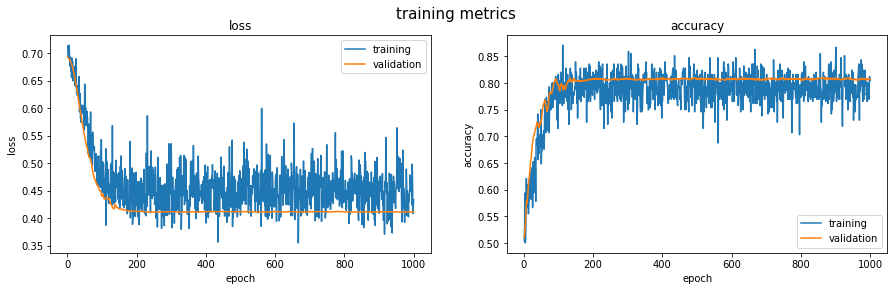

In [ ]:
epochs_ = range(1,epochs+1)

# Displaying images and targets side by side
fig, axarr = plt.subplots(1, 2,figsize=(15,4))
fig.suptitle('training metrics',fontsize=15)
axarr[0].plot(epochs_,train_losses,label='training')
axarr[0].plot(epochs_,val_losses,label='validation')
axarr[0].set_xlabel("epoch")
axarr[0].set_ylabel("loss")
axarr[0].legend()
axarr[0].set_title("loss")
axarr[1].plot(epochs_,train_accs,label='training')
axarr[1].plot(epochs_,val_accs,label='validation')
axarr[1].set_xlabel("epoch")
axarr[1].set_ylabel("accuracy")
axarr[1].legend()
axarr[1].set_title("accuracy")


plt.show()

## Load top 5 performers and use them as an ensemble

In [ ]:
# Models in descending order of val acccuaracy
PATH1 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/pytorch implementation/saved models/model-val-epoch-156-0.8508018770627063.pth'
PATH2 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/pytorch implementation/saved models/model-val-epoch-153-0.8493837665016502.pth'
PATH3 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/pytorch implementation/saved models/model-val-epoch-152-0.8489497387238724.pth'
PATH4 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/pytorch implementation/saved models/model-val-epoch-179-0.8484297648514851.pth'
PATH5 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/pytorch implementation/saved models/model-val-epoch-174-0.8474456820682068.pth'

def TwoLayerNet():
  model = nn.Sequential(
    nn.Linear(in_features=10084,out_features=1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Dropout(0.85),
    nn.Linear(1000,100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(100,1),
    nn.Sigmoid()
  )
  return model


# Load models from path
model_1 = TwoLayerNet()
model_2 = TwoLayerNet()
model_3 = TwoLayerNet()
model_4 = TwoLayerNet()
model_5 = TwoLayerNet()

def LoadState(model,PATH):
  model.load_state_dict(torch.load(PATH))
  model.eval()

LoadState(model_1,PATH1)
LoadState(model_2,PATH2)
LoadState(model_3,PATH3)
LoadState(model_4,PATH4)
LoadState(model_5,PATH5)


Now, run each model on the test set and combine predictions, taking majority vote as the label

In [ ]:
def get_predictions(model,data_loader):
  accuracies = []
  predictions = []
  for i,batch in enumerate(tqdm(data_loader)):
    inputs = batch['X'].to(device).type(torch.cuda.FloatTensor)
    labels = batch['y'].cpu().numpy()
    model.to(device)
    model.eval()
    with torch.no_grad():
      output = model(inputs)
      # print(output)

      # Make predictions
      preds = output.detach().clone()
      # print(preds)
      preds[preds >= 0.5] = 1
      preds[preds < 0.5 ] = 0
      # print("preds shape: ",preds.shape)
      # print("predictions:",preds)
      # print("label:",labels)
      predictions.append(preds.squeeze().cpu().numpy())

      # Convert target and predictions to numpy
      labels_np = labels
      preds_np = preds.cpu().numpy()

      # 4. Calculate accuracy
      # This needs to be by batch
      acc_sum = (preds_np == labels_np).sum(0)
      # print(acc_sum)
      acc = acc_sum / preds_np.shape[0]
      accuracies.append(np.mean(acc))
      # print("accs:",np.mean(acc))
      # if i == 6:
      #   break
  print(np.mean(accuracies))
  return np.array(predictions)
      

m1_preds = get_predictions(model_1,val_loader)
m2_preds = get_predictions(model_2,val_loader)
m3_preds = get_predictions(model_3,val_loader)
m4_preds = get_predictions(model_4,val_loader)
m5_preds = get_predictions(model_5,val_loader)


0.8506666666666667



0.8493333333333334



0.8488888888888889



0.848



0.8471111111111111


## Load data into numpy arrays for ensemble + random forest evaluation

In [ ]:
# Load data for random forest + NN ensemble evaluation
def load_data(path):
  data = pd.read_csv(path).to_numpy()
  X = data[:,1:]
  y = data[:,0]
  y[y == -1] = 0
  return X,y

%time X,y = load_data(TRAINING_PATH_TF)
%time X_val, y_val = load_data(TESTING_PATH_TF)
%time Xm,ym = load_data(TRAINING_PATH)
%time Xm_val, ym_val = load_data(TESTING_PATH)

CPU times: user 58.4 s, sys: 2.42 s, total: 1min
Wall time: 1min 4s
CPU times: user 7.82 s, sys: 166 ms, total: 7.99 s
Wall time: 14.5 s
CPU times: user 55.3 ms, sys: 15 ms, total: 70.3 ms
Wall time: 5 s
CPU times: user 12.8 ms, sys: 36 µs, total: 12.8 ms
Wall time: 1.22 s


Combine these preds into 1 and evaluate accuracy

In [ ]:
preds = m1_preds + m2_preds + m3_preds + m4_preds + m5_preds
for i,pred in enumerate(preds):
  if pred >= 3:
    preds[i] = 1
  else:
    preds[i] = 0

print(m1_preds[0:10])
print(m2_preds[0:10])
print(m3_preds[0:10])
print(m4_preds[0:10])
print(m5_preds[0:10])
print(preds[0:10])

# Get accuracy
equal = np.equal(preds,y_val)
acc = np.sum(equal)/y_val.shape[0]
print("ensemble test acc: ",acc)

[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
ensemble test acc:  0.8493333333333334


Now, run on eval set and return. Additionally, return the eval set of the best classifier m1.

In [ ]:
# Load eval data
%time X_eval, y_eval = load_data(EVAL_PATH_TF)

CPU times: user 19.1 s, sys: 1.31 s, total: 20.4 s
Wall time: 20.6 s


In [ ]:
# eval ids
def load_ids(file_path):
  with open(file_path) as f:
    raw_data = [int(line.split()[0]) for line in f]
  # print(raw_data)
  return raw_data

eval_ids = np.reshape(np.array(load_ids(EVAL_IDS),dtype=np.int32),(X_eval.shape[0],1))
# print(eval_ids)

m1_preds = get_predictions(model_1,eval_loader)
m2_preds = get_predictions(model_2,eval_loader)
m3_preds = get_predictions(model_3,eval_loader)
m4_preds = get_predictions(model_4,eval_loader)
m5_preds = get_predictions(model_5,eval_loader)

preds = m1_preds + m2_preds + m3_preds + m4_preds + m5_preds
for i,pred in enumerate(preds):
  if pred >= 3:
    preds[i] = 1
  else:
    preds[i] = 0

predictions = np.reshape(preds,(X_eval.shape[0],1))
print(predictions.shape)
print(predictions)
eval_out = np.hstack((eval_ids,predictions))
print(eval_out.shape)
print(eval_out)
eval_df = pd.DataFrame(data = eval_out,index = None,columns=['example_id','label'])
save_to_path = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/nn_ensemble_evals.csv'
eval_df.to_csv(path_or_buf=save_to_path,index=False)


0.5457142857142857



0.5466666666666666



0.5474285714285714



0.5161904761904762



0.5163809523809524
(5250, 1)
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
(5250, 2)
[[0.000e+00 1.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 0.000e+00]
 ...
 [5.247e+03 1.000e+00]
 [5.248e+03 0.000e+00]
 [5.249e+03 0.000e+00]]


Now, run the predictions using only my best model.

In [ ]:

predictions = np.reshape(m1_preds,(X_eval.shape[0],1))
# print(predictions.shape)
# print(predictions)
eval_out = np.hstack((eval_ids,predictions))
# print(eval_out.shape)
# print(eval_out)
eval_df = pd.DataFrame(data = eval_out,index = None,columns=['example_id','label'])
save_to_path = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/nn_evals.csv'
eval_df.to_csv(path_or_buf=save_to_path,index=False)

## Feature extractor 

Let's adapt my model to spit out the second to last layer

In [ ]:

# For resnet
feat_ext = torch.nn.Sequential(*list(model_1.children())[:-5]) #Using model_1 here
print(feat_ext)

# gives me a 100 element feature vector
# Can transform my feature space this way. May be good for 
# random forest?
feat_size = 100
X_train = np.empty(shape=(len(train_data),feat_size))
y_train = np.empty(shape=(len(train_data),1))
X_test = np.empty(shape=(len(val_data),feat_size))
y_test = np.empty(shape=(len(val_data),1))
X_eval = np.empty(shape=(len(eval_data),feat_size))
y_eval = np.empty(shape=(len(eval_data),1))

# Loop through datasets to extract feats
def feat_extractor(data_loader,X,y,feat_ext):
  model = feat_ext
  model.to(device)
  model.eval()
  for i,batch in enumerate(tqdm(data_loader)):
    inputs = batch['X'].to(device).type(torch.cuda.FloatTensor)
    labels = batch['y'].cpu().numpy()
    with torch.no_grad():
      output = model(inputs)
      feat_vec = output.squeeze().cpu().numpy()
      # Store in arrays
      X[i,:] = feat_vec
      y[i,:] = labels

feat_extractor(train_loader,X_train,y_train,feat_ext)
feat_extractor(val_loader,X_test,y_test,feat_ext)
feat_extractor(eval_loader,X_eval,y_eval,feat_ext)


Sequential(
  (0): Linear(in_features=10084, out_features=1000, bias=True)
  (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.85, inplace=False)
  (4): Linear(in_features=1000, out_features=100, bias=True)
)


Examine feature vectors + save them

In [ ]:
outfile1 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/X_train_vec.npy'
outfile2 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/y_train_vec.npy'
outfile3 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/X_test_vec.npy'
outfile4 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/y_test_vec.npy'
outfile5 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/X_eval_vec.npy'
outfile6 = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/y_eval_vec.npy'
np.save(outfile1, X_train)
np.save(outfile2, y_train)
np.save(outfile3, X_test)
np.save(outfile4, y_test)
np.save(outfile5, X_eval)
np.save(outfile6, y_eval)

## Let's try random forest as well.

Maybe I can use the second to last layer of my neural net as my input features to random forest.

Fit feature vec outputs and evaluate my random forest.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 



In [ ]:
for i in range(5,30):
  clf = RandomForestClassifier(max_depth=i+1, random_state=0, criterion='gini')
  %time clf.fit(X_train, np.ravel(y_train))
  score = clf.score(X_test,np.ravel(y_test))
  print(i,':',score)


CPU times: user 8.13 s, sys: 7.53 ms, total: 8.14 s
Wall time: 8.15 s
5 : 0.8435555555555555
CPU times: user 9.15 s, sys: 8.49 ms, total: 9.16 s
Wall time: 9.15 s
6 : 0.8444444444444444
CPU times: user 10.1 s, sys: 2.55 ms, total: 10.1 s
Wall time: 10.1 s
7 : 0.8422222222222222
CPU times: user 11.1 s, sys: 6.49 ms, total: 11.1 s
Wall time: 11.1 s
8 : 0.8435555555555555
CPU times: user 12.2 s, sys: 3.65 ms, total: 12.2 s
Wall time: 12.2 s
9 : 0.8408888888888889
CPU times: user 12.9 s, sys: 5.55 ms, total: 12.9 s
Wall time: 12.9 s
10 : 0.8431111111111111
CPU times: user 13.8 s, sys: 2.28 ms, total: 13.8 s
Wall time: 13.8 s
11 : 0.8448888888888889
CPU times: user 14.1 s, sys: 5.38 ms, total: 14.1 s
Wall time: 14.1 s
12 : 0.8426666666666667
CPU times: user 14.6 s, sys: 6.56 ms, total: 14.6 s
Wall time: 14.6 s
13 : 0.8457777777777777
CPU times: user 15.2 s, sys: 10.4 ms, total: 15.2 s
Wall time: 15.2 s
14 : 0.8448888888888889
CPU times: user 15.3 s, sys: 9.39 ms, total: 15.3 s
Wall time: 15

Run my random forest on eval set, using a depth of 12.

In [ ]:
clf = RandomForestClassifier(max_depth=12, random_state=0, criterion='gini')
%time clf.fit(X_train, np.ravel(y_train))


CPU times: user 13.8 s, sys: 5.78 ms, total: 13.8 s
Wall time: 13.8 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predictions = clf.predict(X_eval)

# eval ids
def load_ids(file_path):
  with open(file_path) as f:
    raw_data = [int(line.split()[0]) for line in f]
  # print(raw_data)
  return raw_data

eval_ids = np.reshape(np.array(load_ids(EVAL_IDS),dtype=np.int32),(X_eval.shape[0],1))


print(predictions)
predictions = np.reshape(predictions,(X_eval.shape[0],1))
# print(predictions.shape)
# print(predictions)
eval_out = np.hstack((eval_ids,predictions))
# print(eval_out.shape)
# print(eval_out)
eval_df = pd.DataFrame(data = eval_out,index = None,columns=['example_id','label'])
save_to_path = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/rf_evals.csv'
eval_df.to_csv(path_or_buf=save_to_path,index=False)



[1. 0. 0. ... 1. 0. 0.]


## Random forest eval on just misc attrs

In [ ]:

for i in range(5,30):
  clf = RandomForestClassifier(max_depth=i+1, random_state=0, criterion='gini')
  %time clf.fit(Xm, ym)
  score = clf.score(Xm_val,ym_val)
  print(i,':',score)


CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 557 ms
5 : 0.7928888888888889
CPU times: user 579 ms, sys: 0 ns, total: 579 ms
Wall time: 579 ms
6 : 0.7937777777777778
CPU times: user 639 ms, sys: 0 ns, total: 639 ms
Wall time: 639 ms
7 : 0.7915555555555556
CPU times: user 678 ms, sys: 0 ns, total: 678 ms
Wall time: 677 ms
8 : 0.7946666666666666
CPU times: user 747 ms, sys: 913 µs, total: 748 ms
Wall time: 747 ms
9 : 0.7951111111111111
CPU times: user 743 ms, sys: 0 ns, total: 743 ms
Wall time: 741 ms
10 : 0.7955555555555556
CPU times: user 832 ms, sys: 0 ns, total: 832 ms
Wall time: 830 ms
11 : 0.7946666666666666
CPU times: user 877 ms, sys: 888 µs, total: 877 ms
Wall time: 877 ms
12 : 0.7946666666666666
CPU times: user 900 ms, sys: 948 µs, total: 901 ms
Wall time: 900 ms
13 : 0.7928888888888889
CPU times: user 927 ms, sys: 889 µs, total: 928 ms
Wall time: 927 ms
14 : 0.7933333333333333
CPU times: user 948 ms, sys: 947 µs, total: 949 ms
Wall time: 948 ms
15 : 0.79111111111

## Scraps

In [ ]:
model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# class Random_Weight(nn.Module):
#   def __init__(self, *args):
#       super().__init__()
#       self.args = args
#   def forward(self,x):
#       return random_weight(self.args)

# class Zero_Weight(nn.Module):
#   def __init__(self,args):
#     super().__init__()
#     self.args = args
#   def forward(self,x):
#     return zero_weight((self.args,))

model = nn.Sequential(
    nn.Conv2d(3,channel_1,5,padding=2,bias=True),
    # Random_Weight(channel_1,3,5,5),
    # Zero_Weight(channel_1),
    nn.ReLU(),
    nn.Conv2d(channel_1,channel_2,3,padding=1,bias=True),
    # Random_Weight(channel_2,channel_1,3,3),
    # Zero_Weight(channel_2),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2*32*32,10,bias=True),
    # Random_Weight(10,channel_2*32*32),
    # Zero_Weight(10)
)

# loop through now and initialize weights using my functions.. I guess? 
# Super unclear how to initialize weight with the sequential API. 
# This seems to help: https://www.thetopsites.net/article/52545824.shtml
# def init_weights(m):
#     if type(m) == nn.Linear:
#       # torch.nn.init.xavier_uniform(m.weight)
#       # m.bias.data.fill_(0.01)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)


# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


In [ ]:
# Define my unit block I'll be using
class ConvBlock(nn.Module):
  def __init__(self, channel_1, channel_2,filter,padding):
      super().__init__()
      # batchnorm
      self.bn = nn.BatchNorm2d(channel_1)
      # conv
      self.conv = nn.Conv2d(channel_1,channel_2,filter,padding=padding)
      nn.init.kaiming_normal_(self.conv.weight)
      
  def forward(self, x):
      z = self.conv(F.relu(self.bn(x)))
      return z

class ConvReluPool(nn.Module):
  def __init__(self,channels,filter=3,padding=1):
    super().__init__()
    self.conv1 = nn.Conv2d(channels[0],channels[1],filter,padding=padding)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.conv2 = nn.Conv2d(channels[1],channels[2],filter,padding=padding)
    nn.init.kaiming_normal_(self.conv2.weight)
    self.pool = nn.MaxPool2d(2,2) # this out will be channels[2] 

  def forward(self,x):
    z = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
    return z



channels = [16, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
model = nn.Sequential(
    # A few convs to get things going
    nn.Conv2d(3,channels[0],5,padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(channels[1],channels[2],5,padding=2,bias=True),

    # Starting into my blocks
    ConvBlock(channels[2],channels[3],5,2),
    ConvBlock(channels[3],channels[4],3,1),
    ConvBlock(channels[4],channels[5],3,1),

    # Lets throw some pooling layers
    ConvReluPool(channels[5:8]),
    ConvReluPool(channels[8:11]),

    # Output layer
    # nn.ReLU(),
    Flatten(),
    nn.Linear(channels[10]*8*8,channels[11],bias=True),
    nn.Linear(channels[11],channels[12]),
    nn.Linear(channels[12],10)
)


# Using adam for my optimizer
learning_rate = 5e-4
weight_decay = 0
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)